 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Séance 3, Notebook 1 : Problèmes d'optimisation - l'exemple du QAOA</h2>
<h3> Professeur: Durantin Gautier</h3>
</div>
    
    

### Objectifs du notebook
    
Ce notebook vise à introduire l'emploi de cricuits encodant un problème complet, via l'exemple de l'optimisation et plus précisément du **Quantum Approximate Optimization Algorithm (QAOA)**.
L'application de l'algorithme se fait sur un cas simple d'optimisation de portefeuille d'action, selon la méthode de la variance minimale.
    
### Imports
    
Le notebook, comme la plupart des applications qui seront décrites dans ce module, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

Les librairies suivantes sont également requises pour les applications proposées ici :
- *numpy* : pour la récupération du dataset
- *matplotlib* : pour la visualisation des données

In [62]:
from qiskit_aer.primitives import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.circuit.library import QAOAAnsatz

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from scipy.optimize import minimize

import numpy as np
import itertools

import matplotlib.pyplot as plt

## 1. Chargement et visualisation des données

Le fichier $stock\_vals.npy$ proposé pour le problème contient l'historique des valeurs journalières de clôture de 5 actions différentes, pour un historique s'étalant du **1er janvier 2000 au 31 mars 2020**.

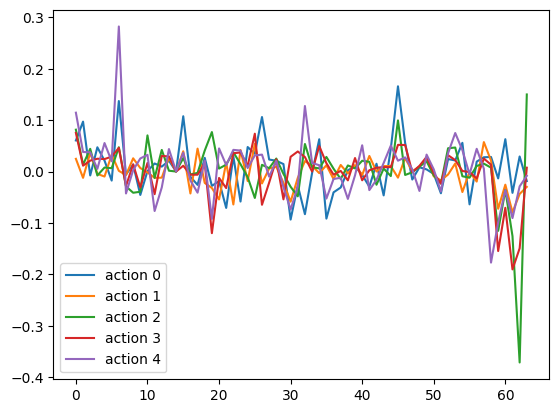

In [63]:
values=np.load("stock_vals.npy")

for i, action in enumerate(values):
    plt.plot(action,label="action "+str(i))
plt.legend()

## 2. Formulation du problème d'optimisation : portefeuille de variance minimale

Afin d'appliquer le QAOA qui nécessitera un Hamiltonien, on cherche à se ramener à une forme QUBO de formulation du problème d'optimisation. Pour rappel, les problèmes QUBO sont formulés avec la fonction de cout suivante :

$$ C(x) = x^T Q x + c^T x $$

### 2.1. Description du portefeuille

Si on doit choisir parmi $n$ actions, on note $X=[x_0,x_1,..,x_{n-1}]$ le vecteur décrivant un portefeuille. Les $x_i$ valent tous $0$ ou $1$, et représentent la présence de l'action dans le portefeuille (1 si l'action est présente dans le portefeuille, 0 sinon)

### 2.2. Calcul de la variance du portefeuille

De manière générale, on peut exprimer la variance attendue de la valeur du portefeuille de la manière suivante :

$$ V(x)=\sum_{i=0}^{n-1} Var(i)x_i^2 + \sum_{i \neq j} Covar(i,j)x_ix_j$$

Où $Var(i)$ est la variance de l'action i, et $Covar(i,j)$ est la covariance des actions i et j.

Si on note $\Sigma$ la matrice des variances covariances, de terme $\Sigma_{i,j}=Covar(i,j)$, alors on peut écrire :

$$ V(x) = x^T\Sigma x $$

### 2.3. Calcul du revenu du portefeuille

On peut écrire le revenu du portefeuille sous la forme suivante :

$$ Rev(x) = \sum_{i=0}^{n-1} \mu_i x_i $$

Où $\mu_i$ représente le revenu moyen de l'action i. On peut alors écrire sous forme matricielle :

$$ Rev(x) = \mu^T x $$

### 2.4. Formulation du problème

Une des approches possibles du problème d'optimisation de portefeuille consiste à maximiser son revenu tout en minimisant sa variance. On cherche donc à minimiser le critère $F$ suivant :

$$F(x) = V(x) - Rev(x) = x^T\Sigma x - \mu^T x $$

On remarque que le critère correspond bien à une formulation QUBO

### 2.5. Implémentation du critère


<div class="alert alert-block alert-info">
<ul>
    <li>Calculer les matrices $\Sigma$ et $\mu$ correspondant au problème d'optimisation.
    <li>Compléter la fonction $get\_criterion$ qui calcule le critère de coût d'un portefeuille
</ul>
</div>

In [64]:
sigma = np.cov(values)  #a compléter
print("sigma =", sigma)

mu = np.mean(values, axis=1)  #a compléter
print("mu =", mu)

def get_criterion(x: np.ndarray, sigma: np.ndarray, mu : np.ndarray):
   return np.dot(x.T, np.dot(sigma, x)) - np.dot(mu, x)

sigma = [[2.53453598e-03 4.73561907e-05 3.33074587e-04 4.71131784e-04
  1.12588116e-03]
 [4.73561907e-05 8.58941979e-04 5.10741761e-04 8.25108028e-04
  4.58187264e-04]
 [3.33074587e-04 5.10741761e-04 3.99190646e-03 1.77878869e-03
  1.16714562e-03]
 [4.71131784e-04 8.25108028e-04 1.77878869e-03 2.42718048e-03
  1.43768330e-03]
 [1.12588116e-03 4.58187264e-04 1.16714562e-03 1.43768330e-03
  3.72234717e-03]]
mu = [ 0.0083047  -0.00233733  0.00160511 -0.00122767  0.00552846]


In [65]:
#Exemple 
x1=np.array([0,0,1,0,0])
x2=np.array([0,1,0,0,0])

print("critère du portefeuille",x1," :",get_criterion(x1,sigma,mu))
print("critère du portefeuille",x2," :",get_criterion(x2,sigma,mu))

critère du portefeuille [0 0 1 0 0]  : 0.00238680054223257
critère du portefeuille [0 1 0 0 0]  : 0.0031962717450077813


### 2.6 Recherche du portefeuille optimal par une méthode brute-force

Pour servir de référence, on propose ici d'utiliser une méthode brute-force d'otpimisation. Pour cela, on calcule le coût de chaque portefeuille possible.

In [66]:
combinations = list(itertools.product(*[[0,1]]*5))

values = []
for combination in combinations:
  values.append((combination, get_criterion(np.array(combination),sigma,mu)))



<div class="alert alert-block alert-info">
<ul>
    <li>Déterminer le meilleur portefeuille possible à partir de l'approche brute-force
</ul>
</div>

In [67]:
best= [comb for comb, val in values if val==min(val for _,val in values)]
print("Meilleur portefeuille(s) :", best)

Meilleur portefeuille(s) : [(1, 0, 0, 0, 0)]


## 3. Dérivation du Hamiltonien

### 3.1. Formulation

On cherche le Hamiltonien $H_c$ tel que :

$$ H_c |x⟩ = C(x) |x⟩ $$

On se place dans le cas général où $C(x)=x^TQx + c^Tx$

<div class="alert alert-block alert-info">
<ul>
    <li>Montrer que si on note $Z_i = IIZII$ (où le Z se trouve sur le i-ième qubit), alors on a $\frac{1-Z_i}{2}|x⟩=x_i|x⟩$
    <li>En déduire la forme du Hamiltonien $H_c$ comme une somme d'opérateurs de Pauli $Z_i$    
</ul>
</div>

<div class="alert alert-block alert-info">
<ul>
    <li>Compléter la fonction ci dessous permettant de calculer l'opérateur Hamiltonien correspondant au problème, en utilisant les matrices $\Sigma$ et $\mu$ définies précédemment
</ul>
</div>

In [68]:
def get_operator(sigma: np.ndarray, mu : np.ndarray):
    num_nodes = len(mu)
    pauli_list = [] #contient la liste des matrices de Pauli à utiliser
    coeffs = [] #contient les coefficients associées à chaque matrice de Pauli

    #Termes en ZiZj
    for i in range(num_nodes):
        for j in range(i):
            if sigma[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(sigma[i,j]/4)

    #Termes en Zi
    for i in range(num_nodes):
            x_p = np.zeros(num_nodes, dtype=bool)
            z_p = np.zeros(num_nodes, dtype=bool)
            z_p[i] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(mu[i]/2-np.sum(sigma[i])/2)

    #shift = termes constants
    shift=np.sum(sigma)/4-np.sum(mu)/2
    pauli_list.append('IIIII')
    coeffs.append(shift)

    return SparsePauliOp(pauli_list, coeffs=coeffs)

problem_operator = get_operator(sigma,mu)

In [69]:
problem_operator

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IIZZI', 'IZIIZ', 'IZIZI', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZIZII', 'ZZIII', 'IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIII'],
              coeffs=[ 1.18390477e-05+0.j,  8.32686468e-05+0.j,  1.27685440e-04+0.j,
  1.17782946e-04+0.j,  2.06277007e-04+0.j,  4.44697173e-04+0.j,
  2.81470290e-04+0.j,  1.14546816e-04+0.j,  2.91786406e-04+0.j,
  3.59420825e-04+0.j,  1.89635946e-03+0.j, -2.51883249e-03+0.j,
 -3.08827560e-03+0.j, -4.08378015e-03+0.j, -1.19139462e-03+0.j,
  1.52464620e-03+0.j])

## 4. Vers le QAOA

### 4.1. Théorème adiabatique

***Si un système quantique dans un état d'énergie extremum est pertubé de manière adiabatique (i.e. suffisamment lentement), alors il demeurera dans son état d'énergie extremum.***

L'idée du QAOA va donc être de placer le système dans un état correspondant ) l'extremum d'énergie d'un Hamiltonien **simple**, puis de perturber ce Hamiltonien de manière adiabatique jusqu'à ce qu'il atteigne le Hamiltonien correspondant au problème. On va donc écrire :

$$H(t)=\frac{t}{T} H_C + (1-\frac{t}{T}) H_M$$

Où $H_C$ est le Hamiltonien correspondant au problème, $H_M$ est le Hamiltonien initial (simple), et $T$ est choisi grand pour assurer une transition adiabatique.

### 4.2. Evolution d'un système quantique

D'après l'équation de Schrödinger, l'évolution d'un système quantique de Hamiltonien $H$ est donnée par :

$$H |\Phi (t)⟩ = i \hbar \frac{\partial |\Phi (t)⟩}{\partial t}$$ 

Ce qui donne, pour un $H$ indépendant du temps :

$$|\Phi (t)⟩ = e^{-\frac{iHt}{\hbar}} |\Phi (0)⟩$$ 

### 4.3. Expression du QAOA

Pour un Hamiltonien $H_C = H_1 + H_2$, on définit l'opérateur d'évolution temporelle à partir de l'équation de Schrödinger décrite plus haut :

$$ U(t) = e^{-\frac{iH_Ct}{\hbar}} = e^{-\frac{i(H_1+H_2)t}{\hbar}}$$

Pour des matrices commutatives : $$e^{A+B} = e^{A}e^{B}$$
Dans le cas général, on peut toutefois utiliser la formule de Trotter-Suzuki :

$$e^{A+B} = (e^{\frac{A}{r}}e^{\frac{B}{r}})^r $$

Où r est un entier (l'approximation est d'autant meilleure que r est grand)

Si on choisit le Hamiltonien de mélange $H_M$ comme $H_M=\sum_i X_i$, dont les état extremums d'énergie sont ses vecteurs propres $|+⟩$ et $|-⟩$, alors on trouve le circuit général du QAOA :

In [77]:
#nombre de repetitions :
r = 9

circuit=QAOAAnsatz(cost_operator=problem_operator, reps=r)
# circuit.decompose().draw('mpl')

Ici, ce circuit ne réalise qu'une approximation du recuit (via l'approximation de Trotter Suzuki). Pour obtenir les meilleurs résultats, il faut donc **ajuster les paramètres du circuit pour minimiser le coût (c.a.d. minimiser l'espérance mathématique du Hamiltonien, vu la manière dont le Hamiltonien a été défini)

In [78]:
#paramètres initiaux arbitraires
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]*r

#ce vecteur contiendra les coûts mesurés à chaque étape
cost_vals=[]

In [79]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    #Cette fonction estime le coût pour chaque configuration des paramètres, via le calcul de l'espérance mathématique du Hamiltonien.
    pass_manager = generate_preset_pass_manager(1, AerSimulator())
    isa_qc=pass_manager.run(ansatz.assign_parameters(params))
    pub = (isa_qc, hamiltonian)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    cost_vals.append(cost)
    return cost

On utilise alors n'importe quel optimiseur pour trouver les paramètres optimaux à appliquer au circuit pour minimiser son espérance mathématique :

In [80]:
estimator = Estimator()
estimator.options.default_shots = 1000
result = minimize(
        cost_func_estimator,
        init_params,
        args=(circuit, problem_operator, estimator),
        method="COBYLA",
        tol=1e-1,
    )
# print(result)

On vérifie alors graphiquement que le choix des paramètres a bien permis de réduire le coût

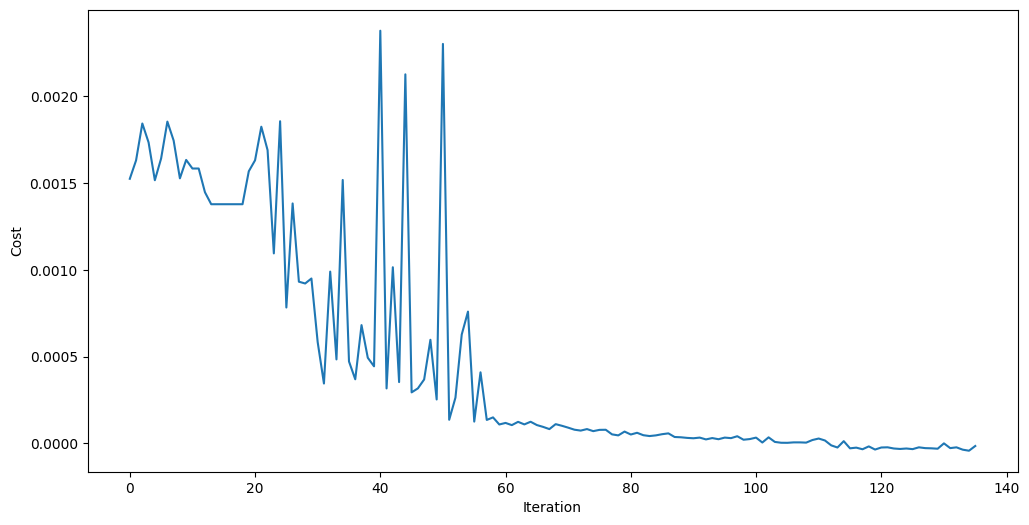

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(cost_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [82]:
#Definition du circuit optimal pour le QAOA
optimal_parameters = result.x
optimal_qaoa_circuit=circuit.assign_parameters(optimal_parameters)
optimal_qaoa_circuit.measure_all()

# optimal_qaoa_circuit.decompose().draw('mpl')

## 5. Emploi du circuit du QAOA pour résoudre le problème d'optimisation

<div class="alert alert-block alert-info">
<ul>
    <li>A l'aide d'un Sampler, exécuter le circuit QAOA optimal
    <li>Déterminer la solution optimale au problème d'optimisation
    <li>Je souhaite à tout prix investir dans 2 actions (ni plus ni moins). Quelle serait ma stratégie optimale ? 
</ul>
</div>

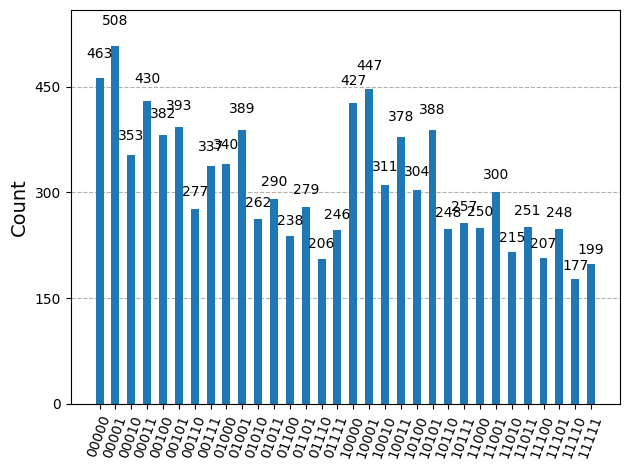

: 

In [ ]:
pass_manager = generate_preset_pass_manager(1, AerSimulator())
sampler=Sampler()

isa_optimal_qaoa_circuit=pass_manager.run(optimal_qaoa_circuit)
job=sampler.run([isa_optimal_qaoa_circuit],shots=10000)
result=job.result()

counts=result[0].data.meas.get_counts()
#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())

<div class="alert alert-block alert-info">
<ul>
    <li>Observer comment évoluent les résultats lorsque le nombre de répétitions du QAOA (r) est plus faible ou plus élevé. Qu'en déduisez vous sur l'utilisabilité de l'algorithme ?
</ul>
</div>

Pour la note de TP = 12
Moyenne = 14.764285714285714
Moyenne = 14.907142857142857
Moyenne = 15.049999999999999
Moyenne = 15.192857142857141
Moyenne = 15.335714285714285
Moyenne = 15.478571428571428
Moyenne = 15.62142857142857
Pour la note de TP = 13
Moyenne = 14.942857142857141
Moyenne = 15.085714285714285
Moyenne = 15.228571428571428
Moyenne = 15.37142857142857
Moyenne = 15.514285714285714
Moyenne = 15.657142857142857
Moyenne = 15.799999999999999
Pour la note de TP = 14
Moyenne = 15.12142857142857
Moyenne = 15.264285714285714
Moyenne = 15.407142857142857
Moyenne = 15.549999999999999
Moyenne = 15.692857142857141
Moyenne = 15.835714285714285
Moyenne = 15.978571428571428
Pour la note de TP = 15
Moyenne = 15.299999999999999
Moyenne = 15.442857142857141
Moyenne = 15.585714285714285
Moyenne = 15.728571428571428
Moyenne = 15.87142857142857
Moyenne = 16.014285714285712
Moyenne = 16.157142857142855
Pour la note de TP = 16
Moyenne = 15.478571428571428
Moyenne = 15.62142857142857
Moyenne = 15.76

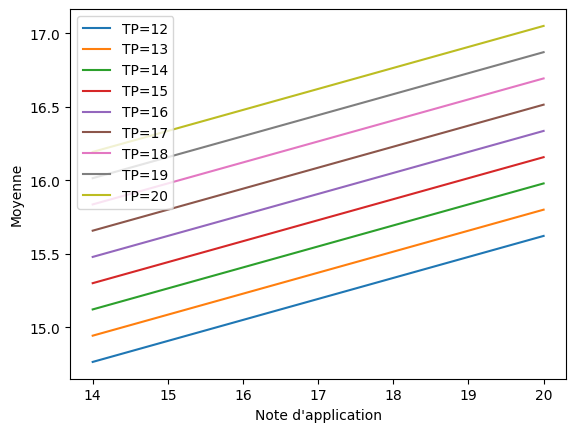